## Análisis del laboratorio de masa

In [60]:
import pandas as pd
import numpy as np

In [61]:
# Import custom libraries
import warnings
import sys
import os

# Subir dos niveles desde notebooks/mod_tecnico/ hasta la raíz del repo
repo_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))  
sys.path.append(repo_path)

# Ahora intenta importar
from src.data_processing import ready_to_import

In [62]:
#Importar librerias para graficar
from matplotlib import pyplot as plt
import seaborn as sns

In [63]:
# Importamos lo necesario para trabajar con consultas SQL

from pandasql import sqldf

# Definir función de consulta
pysqldf = lambda q: sqldf(q, globals())

#### Se carga el dataset 

In [64]:
# Import data
# Import data from Excel files
masa = pd.read_excel('/home/miguel-oscar/Projects/data-INSCO-hub/data/raw/masa.xlsx')

In [65]:
# Resumen estadístico de la tabla
masa.describe()

,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,piece_count
count,462,455,475,476,481,481.000000,481.000000,481.000000
mean,2025-01-30 01:21:02.337662464,2025-02-18 17:56:02.637362432,2025-01-31 01:15:47.368421120,2025-02-09 17:29:44.873949440,2025-02-15 03:11:36.049895936,8.627859,12.295218,5.081081
min,2024-11-06 00:00:00,2024-12-19 00:00:00,2024-03-12 00:00:00,2024-03-13 00:00:00,2025-01-02 00:00:00,0.000000,0.000000,1.000000
25%,2025-01-14 00:00:00,2025-01-31 00:00:00,2025-01-13 12:00:00,2025-01-23 00:00:00,2025-01-24 00:00:00,5.000000,11.000000,1.000000
50%,2025-01-28 00:00:00,2025-02-18 00:00:00,2025-01-29 00:00:00,2025-02-10 00:00:00,2025-02-11 00:00:00,8.000000,14.000000,1.000000
75%,2025-02-25 00:00:00,2025-03-13 00:00:00,2025-02-28 00:00:00,2025-03-07 18:00:00,2025-03-11 00:00:00,11.000000,15.000000,4.000000
max,2025-03-27 00:00:00,2025-04-04 00:00:00,2025-03-28 00:00:00,2025-03-31 00:00:00,2025-03-31 00:00:00,44.000000,30.000000,58.000000
std,NaN,NaN,NaN,NaN,NaN,5.915796,5.237302,8.480350


In [66]:
# Seleccionamos las columnas que contienen fechas y las convertimos a tipo datetime
col_fechas = [col for col in masa.columns if 'date' in col.lower() or 'fecha' in col.lower()]

for col in col_fechas:
    masa[col] = pd.to_datetime(masa[col], errors='coerce', format='%Y/%m/%d')

In [68]:
masa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            462 non-null    object        
 1   so                       481 non-null    object        
 2   assignee                 587 non-null    object        
 3   calibrator               480 non-null    object        
 4   supervisor               481 non-null    object        
 5   approver                 481 non-null    object        
 6   classification           481 non-null    object        
 7   lab_received_date        462 non-null    datetime64[ns]
 8   scheduled_delivery_date  455 non-null    datetime64[ns]
 9   cleaning_date            475 non-null    datetime64[ns]
 10  calibration_date         476 non-null    datetime64[ns]
 11  delivery_date            481 non-null    datetime64[ns]
 12  delivery_time            481 non-nul

In [69]:
# Se hace una copia de la tabla para evitar problemas de referencia
mass = masa.copy()

**Se eliminan las filas donde 'report_number' es NaN y se une el contenido de 'assignee' de las filas con 'report_number' NaN a la fila anterior**

In [70]:
# Esta función es interna y creada para el proceso en el que se va a usar
mass = ready_to_import.to_prepare_db(mass)
# Verificamos nuevamente los tipos de datos de cada columna y la cantidad de datos nulos
mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            462 non-null    object        
 1   so                       462 non-null    object        
 2   assignee                 462 non-null    object        
 3   calibrator               461 non-null    object        
 4   supervisor               462 non-null    object        
 5   approver                 462 non-null    object        
 6   classification           462 non-null    object        
 7   lab_received_date        462 non-null    datetime64[ns]
 8   scheduled_delivery_date  455 non-null    datetime64[ns]
 9   cleaning_date            456 non-null    datetime64[ns]
 10  calibration_date         457 non-null    datetime64[ns]
 11  delivery_date            462 non-null    datetime64[ns]
 12  delivery_time            462 non-nul

### Comparamos la cantidad de calibraciones con los mantenimientos

In [71]:
# Clasificar por tipo de servicio
mass['service_type'] = np.where(
    mass['report_number'].str.startswith('RSM', na=False),
    'Mantenimiento',
    np.where(
        mass['report_number'].str.startswith('CCM', na=False),
        'Calibración',
        'Otros'  # Valor por defecto si ninguna condición se cumple
    )
)

#### Mostramos un dataset con los tipos de servicio

In [73]:
service_type = mass['service_type'].value_counts()
service_type

service_type
Calibración      388
Mantenimiento     74
Name: count, dtype: int64

#### Mostramos un gráfico de barras con los tipos de servicio

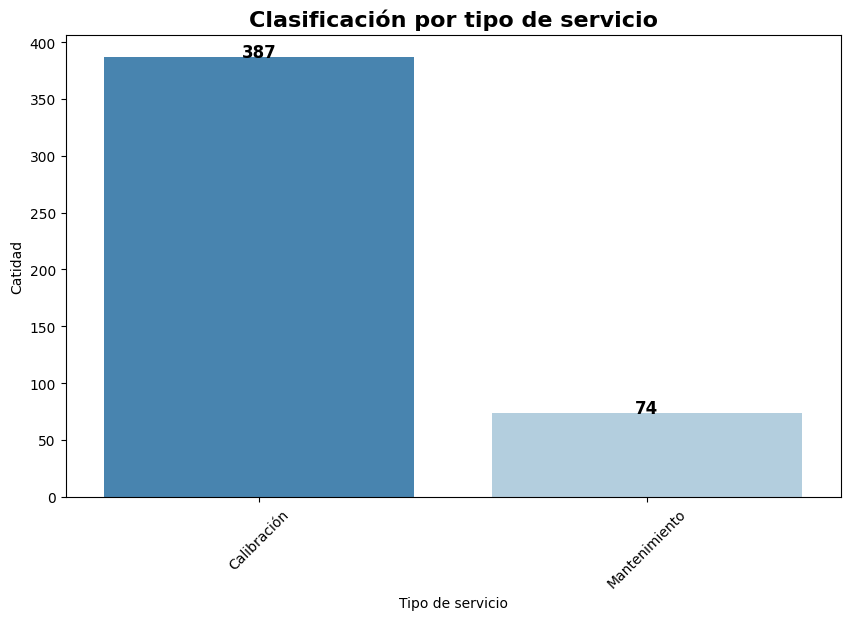

In [18]:
# Crear figura
plt.figure(figsize=(10, 6))

# Gráfico de barras con Seaborn
ax = sns.barplot(x=service_type.index, y=service_type.values, hue=service_type.index, palette='Blues_r', legend=False)

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

# Etiquetas de los ejes
plt.xlabel('Tipo de servicio')
plt.ylabel('Catidad')
plt.title('Clasificación por tipo de servicio', fontsize=16, fontweight='bold')

# Agregar etiquetas en las barras
for i, v in enumerate(service_type.values):
    ax.text(i, v + 0.05, str(v), ha='center', fontsize=12, fontweight='bold')

# Mostrar gráfico
plt.show()

### La gráfica de barras muestra que la mayoría de los servicios son calibraciones (387), en comparación con los mantenimientos, que son solo 74. 

#### Añadir una columna para clasificar los equipos por tipos

In [74]:
classification_map = {
    'I': 'Balanza', 'II': 'Balanza', 'III': 'Balanza', 'IIII': 'Balanza',
    'E1': 'Pesa', 'E2': 'Pesa', 'F1': 'Pesa', 'F2': 'Pesa',
    'M1': 'Pesa', 'M2': 'Pesa', 'M3': 'Pesa',
    '1': 'Pesa', '2': 'Pesa', '3': 'Pesa', '4': 'Pesa',
    '5': 'Pesa', '6': 'Pesa',
    'M': 'NBS', 'S': 'NBS', 'S-1': 'NBS', 'P': 'NBS', 'Q': 'NBS',
    'T': 'NBS', 'F': 'NBS',
    'ONN': 'ONN'
}

# Asignar valores usando map()
mass['equipment_type'] = mass['classification'].map(classification_map).fillna('Otros')

## Análisis de los matentimientos

In [75]:
# Obtenemos los reportes de mantenimiento
mass_maintenance = mass[mass['report_number'].str.startswith('RSM', na=False)]
mass_maintenance

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,...,delivery_time,process_status,assigned_time,service_location,substitution_reason,lab_observations,priority,piece_count,service_type,equipment_type
388,RSM0001.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,...,18.0,ENTREGADO,18.0,LAB,NaN,NaN,ORDINARIO,4.0,Mantenimiento,Pesa
389,RSM0002.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,...,18.0,ENTREGADO,18.0,LAB,NaN,NaN,ORDINARIO,3.0,Mantenimiento,Pesa
390,RSM0003.M/2025,I0036,"Guillermo Guzmán López, Mario de Jesús García,...",Mario de Jesús García,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2025-01-14,2025-02-05,2025-01-20,...,8.0,ENTREGADO,15.0,LAB,NaN,NaN,ORDINARIO,1.0,Mantenimiento,Pesa
391,RSM0003.M/2025,I0036,"Guillermo Guzmán López, Mario de Jesús García,...",Mario de Jesús García,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2025-01-14,2025-02-05,2025-01-20,...,8.0,ENTREGADO,15.0,LAB,NaN,NaN,ORDINARIO,1.0,Mantenimiento,Pesa
392,RSM0003.M/2025,I0036,"Guillermo Guzmán López, Mario de Jesús García,...",Mario de Jesús García,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2025-01-14,2025-02-05,2025-01-20,...,8.0,ENTREGADO,15.0,LAB,NaN,NaN,ORDINARIO,1.0,Mantenimiento,Pesa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,RSM0015.M/2025,I0361,Sergio Cruz Santiago,Sergio Cruz Santiago,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,M1,2025-03-06,2025-03-24,2025-03-12,...,9.0,ENTREGADO,11.0,LAB,NaN,NaN,ORDINARIO,5.0,Mantenimiento,Pesa
458,RSM0016.M/2025,I0361,Sergio Cruz Santiago,Sergio Cruz Santiago,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,M1,2025-03-06,2025-03-24,2025-03-12,...,9.0,ENTREGADO,11.0,LAB,NaN,NaN,ORDINARIO,5.0,Mantenimiento,Pesa
459,RSM0017.M/2025,I0361,Sergio Cruz Santiago,Sergio Cruz Santiago,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,M1,2025-03-06,2025-03-24,2025-03-12,...,9.0,ENTREGADO,11.0,LAB,NaN,NaN,ORDINARIO,5.0,Mantenimiento,Pesa
460,RSM0018.M/2025,I0418,Mario de Jesús García,Mario de Jesús García,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2025-03-14,2025-04-01,2025-03-14,...,10.0,ENTREGADO,11.0,LAB,NaN,NaN,ORDINARIO,1.0,Mantenimiento,Pesa


In [77]:
# Contamos la cantidad de reportes por tipo de equipo
maintenance_per_type = mass_maintenance.groupby('equipment_type')['report_number'].count().sort_values(ascending=False)
maintenance_per_type

equipment_type
Pesa       66
Balanza     8
Name: report_number, dtype: int64

### Gráfico de barras con los servicios de mantenimiento clasificados por tipo

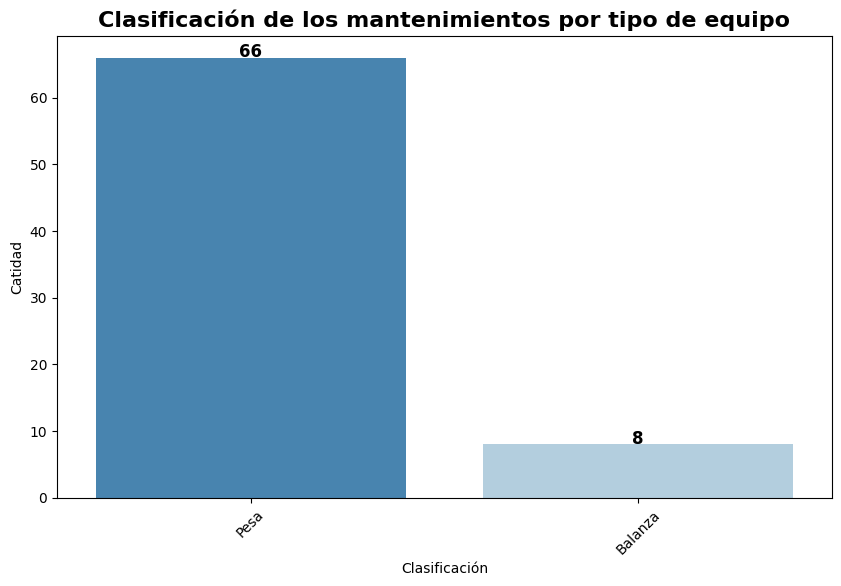

In [22]:
# Crear figura
plt.figure(figsize=(10, 6))

# Gráfico de barras con Seaborn
ax = sns.barplot(x=maintenance_per_type.index, y=maintenance_per_type.values, hue=maintenance_per_type.index, palette='Blues_r', legend=False)

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

# Etiquetas de los ejes
plt.xlabel('Clasificación')
plt.ylabel('Catidad')
plt.title('Clasificación de los mantenimientos por tipo de equipo', fontsize=16, fontweight='bold')

# Agregar etiquetas en las barras
for i, v in enumerate(maintenance_per_type.values):
    ax.text(i, v + 0.05, str(v), ha='center', fontsize=12, fontweight='bold')

# Mostrar gráfico
plt.show()

**El gráfico muestra que en el primer trimestre del año el laboratorio le ha dado mantenimiento a 66 pesas y 8 balanzas.**

### Agrupamos los mantenimientos por su clasificación

In [23]:
# Cantidad de mantenimientos por clasificación
maintenance_class = mass_maintenance.groupby('classification')['report_number'].count().sort_values(ascending=False)
maintenance_class

classification
M1     61
M2      5
I       4
II      3
III     1
Name: report_number, dtype: int64

### Gráfico de barras con los servicios de mantenimiento agrupados por clasificación

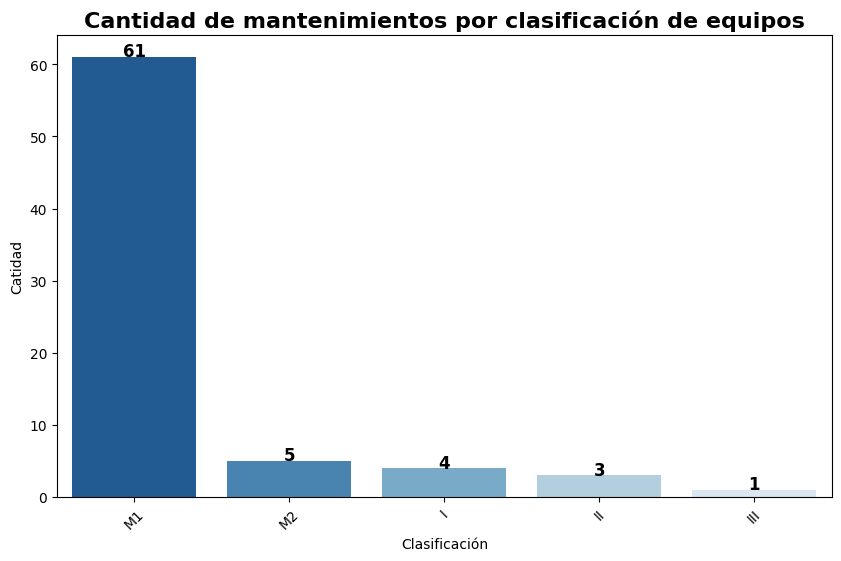

In [24]:
# Crear figura
plt.figure(figsize=(10, 6))

# Gráfico de barras con Seaborn
ax = sns.barplot(x=maintenance_class.index, y=maintenance_class.values, hue=maintenance_class.index, palette='Blues_r', legend=False)

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

# Etiquetas de los ejes
plt.xlabel('Clasificación')
plt.ylabel('Catidad')
plt.title('Cantidad de mantenimientos por clasificación de equipos', fontsize=16, fontweight='bold')

# Agregar etiquetas en las barras
for i, v in enumerate(maintenance_class.values):
    ax.text(i, v + 0.05, str(v), ha='center', fontsize=12, fontweight='bold')

# Mostrar gráfico
plt.show()

#### El gráfico muestra que las pesas del tipo *M1* son las que más mantenimiento han recibido, con un total de 61 servicios. Las balanzas del tipo *III* son las que menos mantenimiento han recibido, con solo 1 servicio.

## Analizamos los mantenimientos teniendo en cuenta su clasificación y la comparativa con sus tiempos asignados y de entrega.

In [25]:
maintenance_time = (mass_maintenance.groupby('classification')[['delivery_time', 'assigned_time', 'piece_count']]
                                               .mean().round(2)
                                               #.unstack(fill_value=0)
                                               #.reset_index()
                                               )  

'''maintenance_time = maintenance_time.rename(
    columns={
        'Tiempo_Entrega': 'delivery_time' ,
        'Tiempo_Asignación':'assigned_time',
        'Cantidad_Piezas':'piece_count'
    }
)'''
maintenance_time

,delivery_time,assigned_time,piece_count
classification,,,
I,3.00,3.75,1.00
II,3.00,3.33,1.00
III,2.00,5.00,1.00
M1,8.38,14.66,2.46
M2,8.00,9.60,12.80


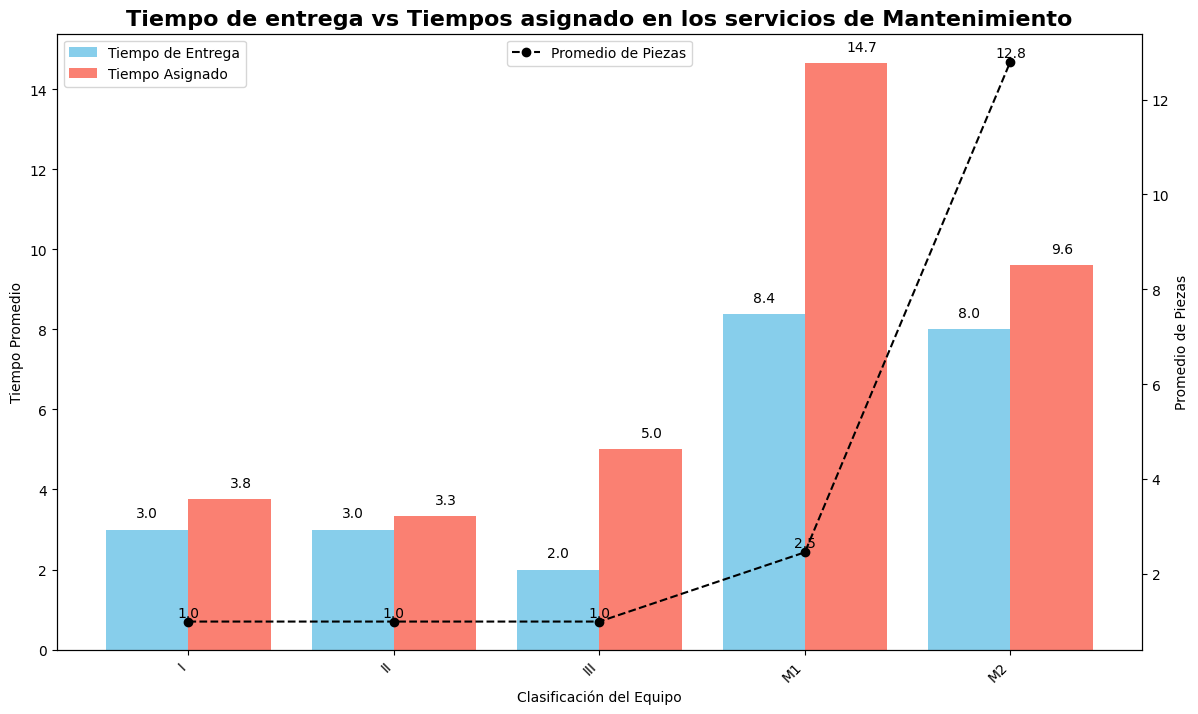

In [26]:
df = maintenance_time.reset_index()

# Configurar figura y ejes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Ancho de las barras
bar_width = 0.4
x = range(len(df))

# Barras agrupadas
bars1 = ax1.bar(x, df['delivery_time'], width=bar_width, color='skyblue', label='Tiempo de Entrega', align='center')
bars2 = ax1.bar([i + bar_width for i in x], df['assigned_time'], width=bar_width, color='salmon', label='Tiempo Asignado', align='center')

# Segundo eje Y para la cantidad de piezas
ax2 = ax1.twinx()
points = ax2.plot([i + bar_width/2 for i in x], df['piece_count'], color='black', marker='o', label='Promedio de Piezas', linestyle='dashed')

# Etiquetas en las barras
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{bar.get_height():.1f}', ha='center', fontsize=10, color='black')
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{bar.get_height():.1f}', ha='left', fontsize=10, color='black')

# Etiquetas en los puntos de cantidad de piezas
for i, txt in enumerate(df['piece_count']):
    ax2.text(i + bar_width/2, txt + 0.1, f'{txt:.1f}', ha='center', fontsize=10, color='black')

# Configurar etiquetas en el eje X
ax1.set_xticks([i + bar_width/2 for i in x])
ax1.set_xticklabels(df['classification'], rotation=45, ha='right', fontsize=10)

# Etiquetas y título
ax1.set_ylabel("Tiempo Promedio")
ax2.set_ylabel("Promedio de Piezas")
ax1.set_xlabel("Clasificación del Equipo")
ax1.set_title("Tiempo de entrega vs Tiempos asignado en los servicios de Mantenimiento", fontsize=16, fontweight='bold')

# Leyendas
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')

plt.show()


# **Conclusiones del Análisis del Gráfico**

## ✅ **Eficiencia en los tiempos de entrega**  
- En la mayoría de los casos, los tiempos de entrega son mucho menores a los asignados.  
- Esto sugiere que la planificación es conservadora.  
- Se podrían ajustar los tiempos asignados para reflejar mejor la realidad y mejorar la eficiencia.

## ✅ **Mayor complejidad en M1 y M2**  
- Estas clasificaciones tienen más piezas y mayores tiempos de entrega.  
- Esto indica que los equipos en estas categorías pueden ser más complejos al momento de darles mantenimiento.  
- La diferencia significativa en piezas utilizadas puede justificar el mayor tiempo de entrega.

## ✅ **Optimización en la planificación**  
- Dado que el tiempo asignado es mayor al tiempo de entrega en la mayoría de los casos, se podrían optimizar los recursos.  
- Ajustar los tiempos asignados evitaría subutilización de recursos y permitiría una planificación más precisa.  

## 💡 **Próximo paso**  
- Analizar si existe una relación directa entre el número de piezas utilizadas y el tiempo de entrega.  
- Determinar si este factor es clave en la planificación del mantenimiento.  


### Eliminamos todos los reportes que no son calibraciones

# Realizar el análisis de las calibraciones

In [27]:
# Se eliminan las filas que no son calibraciones
mass_cal = mass[~mass['report_number'].str.startswith('RSM', na=False)]

In [28]:
# Analizamos la información de la tabla
mass_cal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 387 entries, 0 to 386
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            387 non-null    object        
 1   so                       387 non-null    object        
 2   assignee                 387 non-null    object        
 3   calibrator               387 non-null    object        
 4   supervisor               387 non-null    object        
 5   approver                 385 non-null    object        
 6   classification           387 non-null    object        
 7   lab_received_date        387 non-null    datetime64[ns]
 8   scheduled_delivery_date  382 non-null    datetime64[ns]
 9   cleaning_date            381 non-null    datetime64[ns]
 10  calibration_date         387 non-null    datetime64[ns]
 11  delivery_date            387 non-null    datetime64[ns]
 12  delivery_time            387 non-null    

# Análisis del DataFrame

**📌 Estructura General**  
- **387 registros** | **22 columnas** (5 fechas, 3 numéricas, 14 texto/object)  

**🔍 Hallazgos Clave**  
1. **Variables Temporales** (completas en su mayoría):  
   - `delivery_time` (tiempo de entrega) y `assigned_time` - **0 nulos**  
   - Fechas críticas (`lab_received_date`, `calibration_date`, `delivery_date`) - **100% completas**  
   - `scheduled_delivery_date` y `cleaning_date` - **5-6 nulos**  

2. **Columnas con Datos Faltantes**:  
   - `substitution_reason` (94% nulos) y `lab_observations` (87% nulos) - **Considerar eliminar o imputar**  

3. **Variables Categóricas Relevantes**:  
   - `classification`, `priority`, `service_type`, `equipment_type` - **0 nulos**  
   - Útiles para segmentación (ej: análisis por tipo de equipo o prioridad).  

**⚠️ Siguientes acciones**  
- Limpieza mínima: Revisar filas con `scheduled_delivery_date` nulo.  
- Enfoque analítico: **`delivery_time` vs categorías** (prioridad, tipo de servicio).  
- Columnas opcionales: `substitution_reason` y `lab_observations` aportan poco valor.  


# Análisis de los errores de sustitución antes de realizar el análisis de las calibraciones

In [29]:
# Obtenemos la cantidad de reportes por cada razón de sustitución
subs_reason = mass_cal.groupby('substitution_reason')['report_number'].count().sort_values(ascending=False)
subs_reason


substitution_reason
Solicitud del cliente           14
Error de laboratorio             6
Error del área comercial         2
Error de atención al cliente     1
Name: report_number, dtype: int64

### Se comparan los distintos tipos de errores de sustitución

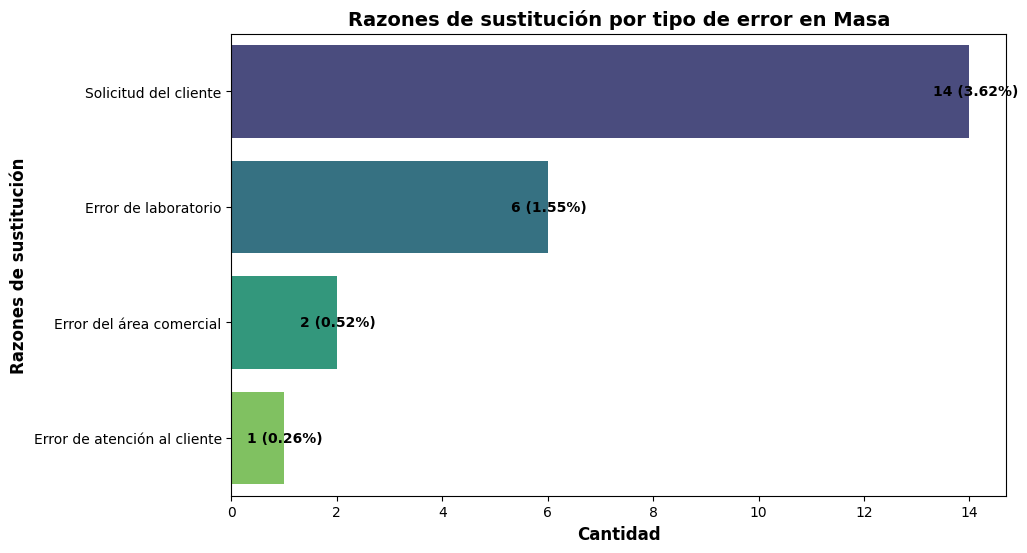

In [30]:
# Calcular el total de sustituciones
total = mass_cal['report_number'].count()

# Crear figura
plt.figure(figsize=(10, 6))

# Gráfico de barras horizontales corregido
ax = sns.barplot(
    y=subs_reason.index, 
    x=subs_reason.values, 
    hue=subs_reason.index,  # Asigna la variable al hue
    palette='viridis', 
    legend=False  # Desactiva la leyenda redundante
)

# Etiquetas y título
plt.xlabel('Cantidad', fontsize=12, fontweight='bold')
plt.ylabel('Razones de sustitución', fontsize=12, fontweight='bold')
plt.title('Razones de sustitución por tipo de error en Masa', fontsize=14, fontweight='bold')

# Agregar anotaciones con valores y porcentajes
for i, v in enumerate(subs_reason.values):
    porcentaje = (v / total) * 100
    ax.text(v - 0.7, i, f"{v} ({porcentaje:.2f}%)", ha='left', va='center', fontsize=10, fontweight='bold')

# Mostrar gráfico
plt.show()



# Análisis de Sustituciones en Masa

**📊 Distribución de Causas**:
- **Principal motivo**: Solicitud del cliente (3.62% del total de informes de calibraciones (máximo))
- **Errores menores**: 
  - Área de atención al cliente (máx 0.26% del total de informes de calibraciones) 


1. **Prioridad de Acción**:
   - Enfocarse en **solicitudes de clientes** (frecuencia alta).


**📌 Recomendación**: **Las razones de sustitución por solicitudes del cliente puede indicar que falta claridad al momento de captar los requerimientos que el cliente necesita, por lo que se recomienda optimizar el proceso en cuestión.**

## Tipos de errores vs Clasificación de equipo

In [31]:
# 1. Crear una copia del DataFrame para preservar los datos originales
df_temp = mass_cal.copy()

# 2. Identificar errores no clasificados (NaN)
df_temp['classification'] = df_temp['classification'].fillna('No clasificado')  # Renombrar NaN

# 3. Agrupar incluyendo la nueva categoría
errores_por_classification = (
    df_temp.groupby(['classification', 'substitution_reason'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
)

# 4. Calcular el TOTAL correcto (suma de razones)
columnas_errores = errores_por_classification.columns.difference(['classification'])
errores_por_classification['Total'] = errores_por_classification[columnas_errores].sum(axis=1)

# 5. Ordenar y mostrar
errores_por_classification = errores_por_classification.sort_values('Total', ascending=False)
errores_por_classification

substitution_reason,classification,Error de atención al cliente,Error de laboratorio,Error del área comercial,Solicitud del cliente,Total
0,E2,1,3,2,7,13
1,F1,0,3,0,5,8
2,M2,0,0,0,2,2


### Se comparan los distintos tipos de errores de sustitución por clasificación de equipo

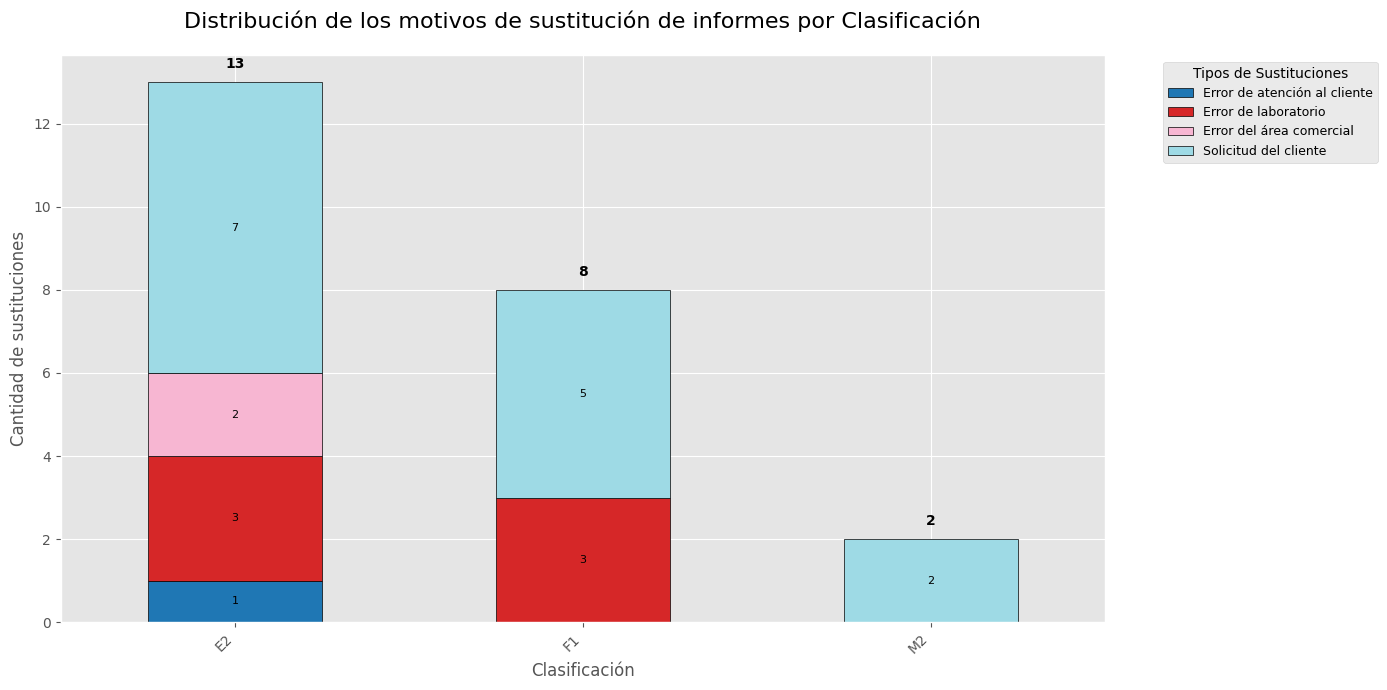

In [32]:
# Configurar el estilo
plt.style.use('ggplot')

# Crear gráfico de barras apiladas
errores_por_classification = errores_por_classification.drop(columns='Total', errors='ignore')  # Eliminar la columna 'Total' para el gráfico
ax = errores_por_classification.set_index('classification').plot(
    kind='bar', 
    stacked=True,
    figsize=(14, 7),
    colormap='tab20',  # Paleta de colores para múltiples categorías
    edgecolor='black',
    linewidth=0.5
)

# Personalizar el gráfico
plt.title('Distribución de los motivos de sustitución de informes por Clasificación', fontsize=16, pad=20)
plt.xlabel('Clasificación', fontsize=12)
plt.ylabel('Cantidad de sustituciones', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Añadir etiquetas de totales encima de cada barra completa
for i, classification in enumerate(errores_por_classification['classification']):
    total = errores_por_classification.set_index('classification').loc[classification].sum()
    ax.text(i, 
            total + (ax.get_ylim()[1] * 0.02),  # Pequeño margen arriba de la barra
            f'{int(total)}', 
            ha='center', 
            va='bottom',
            fontsize=10,
            fontweight='bold',
            color='black')

# Añadir etiquetas para cada segmento (opcional)
for rect in ax.patches:
    height = rect.get_height()
    if height > 0:  # Mostrar solo etiquetas para barras con valores
        ax.text(rect.get_x() + rect.get_width()/2, 
                rect.get_y() + height/2, 
                f'{int(height)}', 
                ha='center', 
                va='center',
                fontsize=8,
                color='black')

# Mejorar la leyenda
plt.legend(
    title='Tipos de Sustituciones',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=9,
    frameon=True
)

# Ajustar márgenes
plt.tight_layout()
plt.show()

## 📌 Hallazgo Principal
**Las pesas E1 son la clasificación más crítica**, representando:
- **13 sustituciones totales** (entre ellas 7 por solicitud del cliente y 3 por errores de laboratorio)
- Esto equivale al **56.52% del total de sustituciones** 

#### Eliminar las filas que contienen los informes que corresponden a las sustituciones por errores

In [33]:
mass_sin_errores = df_temp.drop(df_temp[df_temp['substitution_reason'].notna()].index)

In [34]:
mass_sin_errores.loc[mass_sin_errores['report_number'] == 'CCM0095.M/2025', 'piece_count'] = 95

In [35]:
mass_sin_errores = mass_sin_errores.drop(columns=['substitution_reason'], errors='ignore')
mass_sin_errores.head(10)

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,...,delivery_date,delivery_time,process_status,assigned_time,service_location,lab_observations,priority,piece_count,service_type,equipment_type
0,CCM0001.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Calibración,Pesa
1,CCM0002.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Calibración,Pesa
2,CCM0003.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Calibración,Pesa
3,CCM0004.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Calibración,Pesa
4,CCM0005.M/2025 v0,I0082,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2025-01-21,2025-01-31,2025-01-21,...,2025-01-30,7.0,ENTREGADO,8.0,LAB,Me dan otra pesa para calibrarla y esta si cum...,ORDINARIO,1.0,Calibración,Pesa
5,CCM0005.M/2025 v1,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,Pesa de venta no cumple con la clese E2. cuand...,ORDINARIO,1.0,Calibración,Pesa
6,CCM0006.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Calibración,Pesa
7,CCM0007.M/2025,H2395,Francisco Torres Cabrera,Francisco Torres Cabrera,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,E2,2024-12-06,2025-01-08,2024-12-06,...,2025-01-07,20.0,ENTREGADO,21.0,LAB,NaN,ORDINARIO,22.0,Calibración,Pesa
8,CCM0008.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,...,2025-01-06,18.0,ENTREGADO,18.0,LAB,NaN,ORDINARIO,4.0,Calibración,Pesa
9,CCM0009.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,...,2025-01-06,18.0,ENTREGADO,18.0,LAB,NaN,ORDINARIO,3.0,Calibración,Pesa


In [36]:
# Eliminamos las columnas que no son necesarias
mass_sin_errores = mass_sin_errores.drop(columns=['substitution_reason', 'service_type', 'lab_observations', 'process_status'], errors='ignore')

# Verificamos nuevamente los tipos de datos de cada columna y la cantidad de datos nulos
mass_sin_errores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 0 to 386
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            364 non-null    object        
 1   so                       364 non-null    object        
 2   assignee                 364 non-null    object        
 3   calibrator               364 non-null    object        
 4   supervisor               364 non-null    object        
 5   approver                 362 non-null    object        
 6   classification           364 non-null    object        
 7   lab_received_date        364 non-null    datetime64[ns]
 8   scheduled_delivery_date  359 non-null    datetime64[ns]
 9   cleaning_date            358 non-null    datetime64[ns]
 10  calibration_date         364 non-null    datetime64[ns]
 11  delivery_date            364 non-null    datetime64[ns]
 12  delivery_time            364 non-null    

#### Comenzamos a trabajar sobre esta nueva tabla

In [37]:
# Verificamos los valores nulos de la columna 'approver' en la tabla

resultado = pysqldf("""
    SELECT *
    FROM mass_sin_errores
    WHERE approver IS NULL """)

resultado

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,service_location,priority,piece_count,equipment_type
0,CCM0049.M/2025,H2477,Guillermo Guzmán López,Guillermo Guzmán López,Gabriel Gallardo Camacho,None,F2,2024-12-18 00:00:00.000000,2025-01-15 00:00:00.000000,2024-12-19 00:00:00.000000,2025-01-15 00:00:00.000000,2025-01-15 00:00:00.000000,18.0,18.0,LAB,ORDINARIO,9.0,Pesa
1,CCM0050.M/2025,H2477,Guillermo Guzmán López,Guillermo Guzmán López,Gabriel Gallardo Camacho,None,F1,2024-12-18 00:00:00.000000,2025-01-15 00:00:00.000000,2024-12-19 00:00:00.000000,2025-01-14 00:00:00.000000,2025-01-15 00:00:00.000000,18.0,18.0,LAB,ORDINARIO,12.0,Pesa


In [38]:
#Cambiar el valor de la columna approver a 'Gabriel Gallardo Camacho' para el report_number específico
mass_sin_errores.loc[mass_sin_errores['report_number'].isin(['CCM0049.M/2025', 'CCM0050.M/2025']), 'approver'] = 'Gabriel Gallardo Camacho'

In [39]:
# Verificamos los valores nulos de las columnas con valores faltantes en la tabla

resultado = pysqldf("""
    SELECT report_number, scheduled_delivery_date, cleaning_date, service_location
    FROM mass_sin_errores
    WHERE scheduled_delivery_date IS NULL or cleaning_date IS NULL """)

resultado

,report_number,scheduled_delivery_date,cleaning_date,service_location
0,CCM0091.M/2025,2025-01-28 00:00:00.000000,None,LAB
1,CCM0104.M/2025,None,2025-01-29 00:00:00.000000,SITIO
2,CCM0105.M/2025,None,2025-01-29 00:00:00.000000,SITIO
3,CCM0107.M/2025,None,2025-01-23 00:00:00.000000,SITIO
4,CCM0184.M/2025,2025-02-24 00:00:00.000000,None,LAB
5,CCM0257.M/2025,None,None,SITIO
6,CCM0268.M/2025,2025-03-18 00:00:00.000000,None,LAB
7,CCM0269.M/2025,2025-03-18 00:00:00.000000,None,LAB
8,CCM0374.M/2025,None,None,SITIO


**Los valores faltantes son consistentes con los datos y por tanto se mantienen de esa forma**

##### Buscamos si quedaron algunos valores duplicados

In [40]:
no_dup = mass_sin_errores[mass_sin_errores.duplicated(keep=False)]
no_dup

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,service_location,priority,piece_count,equipment_type
65,CCM0058.M/2025,H2494,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-26,2025-01-20,2025-01-03,2025-01-17,2025-01-20,16.0,16.0,LAB,ORDINARIO,1.0,Pesa
66,CCM0058.M/2025,H2494,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-26,2025-01-20,2025-01-03,2025-01-17,2025-01-20,16.0,16.0,LAB,ORDINARIO,1.0,Pesa


**Lo podemos considerar como un solo certificado con dos piezas distintas**

In [41]:
mass_sin_errores = mass_sin_errores.drop_duplicates()

**Lo podemos considerar como un solo certificado con dos piezas distintas**

In [42]:
mass_sin_errores.loc[mass_sin_errores['report_number'] == 'CCM0058.M/2025', 'piece_count'] = 2

### Análisis de la cantidad de reportes por clasificación de equipo

In [43]:
qty_per_class = mass_sin_errores.groupby(['classification'])['report_number'].count().sort_values(ascending=False)
qty_per_class = qty_per_class.reset_index()
qty_per_class

,classification,report_number
0,E2,142
1,F1,108
2,M1,53
3,F2,21
4,II,11
5,I,8
6,III,5
7,1,4
8,2,4
9,E1,3


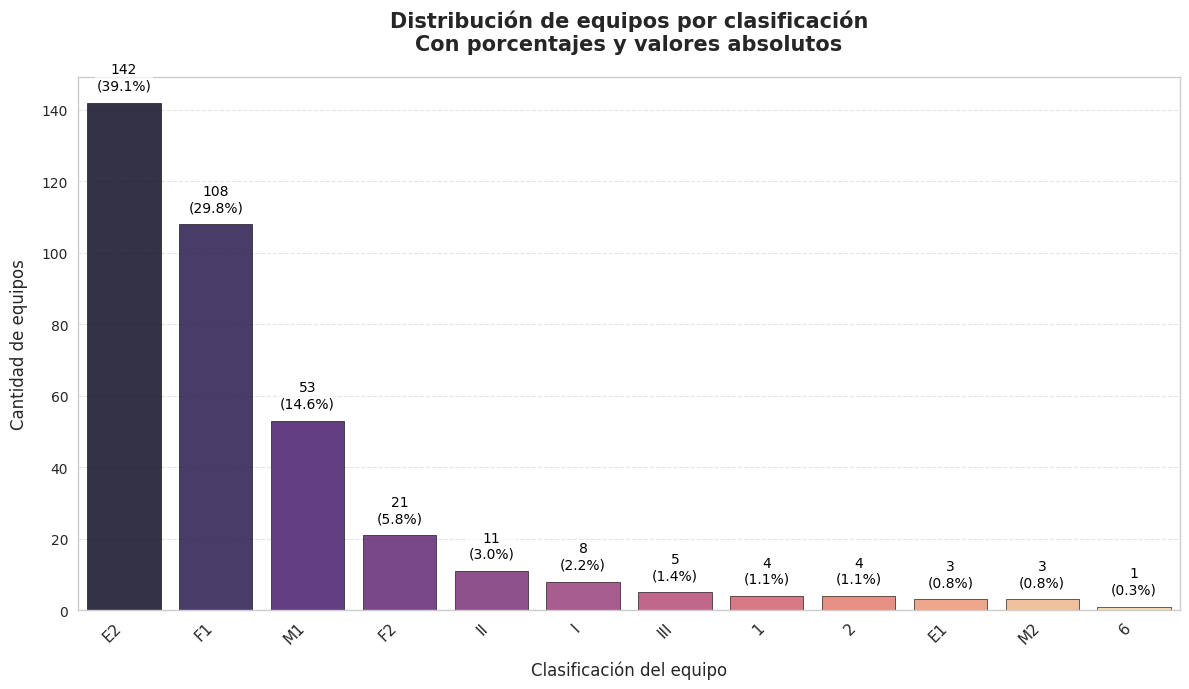

In [44]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Calculamos los porcentajes
total = qty_per_class['report_number'].sum()
qty_per_class['percentage'] = (qty_per_class['report_number'] / total) * 100

ax = sns.barplot(
    x='classification',
    y='report_number',
    hue='classification',  # Added to address warning
    data=qty_per_class,
    palette='magma',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.85,
    dodge=False,  # Prevents side-by-side bars when using hue
    legend=False  # Hides redundant legend
)

# Añadir etiquetas con valores absolutos y porcentajes
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    percentage = qty_per_class['percentage'].iloc[i]
    
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,
        y=height + (0.02 * max(qty_per_class['report_number'])),  # Offset dinámico
        s=f"{height:.0f}\n({percentage:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=10,
        color='black',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )

# Mejorar el título y etiquetas
plt.title("Distribución de equipos por clasificación\nCon porcentajes y valores absolutos", 
          fontsize=15, pad=20, fontweight='bold')
plt.xlabel("Clasificación del equipo", fontsize=12, labelpad=10)
plt.ylabel("Cantidad de equipos", fontsize=12, labelpad=10)

# Rotación y formato de ejes
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=10)

'''# Línea horizontal de referencia
plt.axhline(y=total/len(qty_per_class), color='red', linestyle='--', alpha=0.5, 
            label=f'Promedio: {total/len(qty_per_class):.0f} equipos')
'''
# Cuadrícula y leyenda
plt.grid(axis='y', linestyle='--', alpha=0.5)
#plt.legend(loc='upper right', framealpha=0.9)


# Ajustar márgenes
plt.tight_layout()
plt.show()

### Distribución de Equipos por Clasificación  


### 🔍 Hallazgos Clave  
1. **Dominancia clara**:  
   - La clasificación **E2** concentra el **39.1% del total** (363 equipos)  
   - Las **4 primeras categorías** (E2, F1, M1 Y F2) representan **89.3%** del total (363 equipos) 

2. **Cola larga**:  
   - 7 clasificaciones con ≤3.0% de participación cada una  
   - En conjunto suman solo **7.7%** del total


### Análisis de la cantidad de reportes por el tipo de equipo

In [45]:
res = pysqldf("""
    SELECT equipment_type, COUNT(report_number) AS total_reportes
    FROM mass_sin_errores
    GROUP BY equipment_type """)
res

,equipment_type,total_reportes
0,Balanza,24
1,Pesa,339


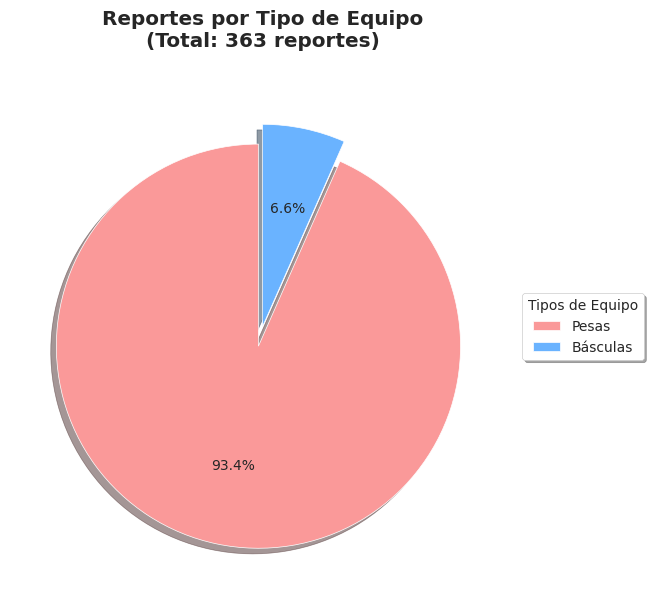

In [46]:
labels = ['Pesas', 'Básculas']
sizes = [339, 24]
colors = ['#fa9999','#6ab3ff']
explode = (0.1, 0)  # Destacar pesas

fig, ax = plt.subplots(figsize=(8,6))
wedges, texts, autotexts = ax.pie(
    sizes, 
    explode=explode, 
    colors=colors,
    autopct='%1.1f%%',
    shadow=True, 
    startangle=90,
    textprops={'fontsize': 10}
)

# Configuración profesional de leyenda
ax.legend(
    wedges,
    labels,
    title="Tipos de Equipo",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    frameon=True,
    shadow=True
)

# Añadir título
plt.title('Reportes por Tipo de Equipo\n(Total: 363 reportes)', 
          fontweight='bold', pad=20)

# Ajustar layout para evitar corte de leyenda
plt.tight_layout()
plt.show()

## 📊 Distribución Global
- **Total reportes analizados**: 363 (100%)
- **Dominancia clara**:
  - **Pesas**: 339 reportes (93.4%)
  - **Básculas**: 24 reportes (6.6%)
#### 📊 Se muestra una dominancia clara de las pesas sobre las básculas, con un 93.4% de los reportes analizados.

## Análisis de los tiempos de entrega por clasificación de equipo

In [47]:
class_del_time = mass_sin_errores.groupby(['classification'])['delivery_time'].mean().round(2).reset_index()
class_del_time

,classification,delivery_time
0,1,12.50
1,2,14.00
2,6,5.00
3,E1,37.33
4,E2,11.63
5,F1,8.80
6,F2,9.05
7,I,2.12
8,II,1.73
9,III,1.20


/tmp/ipykernel_176509/3546774591.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


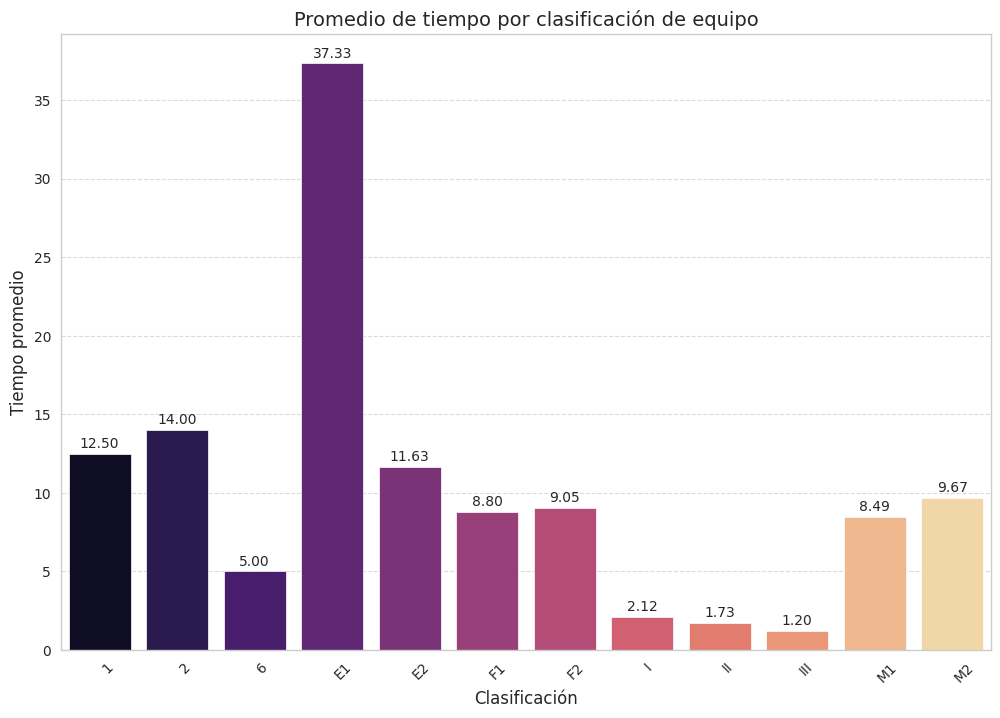

In [48]:

plt.figure(figsize=(12, 8))
# Sintaxis básica
ax = sns.barplot(
    x='classification',  # Variable categórica (eje x)
    y='delivery_time',   # Variable numérica (eje y)
    data=class_del_time,
    #estimator='mean',  # Función de agregación (mean, sum, median, etc.)
    palette='magma',            # Intervalo de confianza (o 'sd' para desviación estándar)
    #color='blue'       # Color de las barras
)

# Añadir los valores en las barras
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,  # Posición horizontal centrada
        y=height + 0.2,                       # Posición vertical (altura + offset)
        s=f"{height:.2f}",                    # Texto (2 decimales)
        ha="center",                           # Alineación horizontal
        va="bottom",                           # Alineación vertical
        fontsize=10
    )

plt.title("Promedio de tiempo por clasificación de equipo", fontsize=14)
plt.xlabel("Clasificación", fontsize=12)
plt.ylabel("Tiempo promedio", fontsize=12)
plt.xticks(rotation=45, ha='left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Solo líneas de cuadrícula en el eje y

plt.show()

# Análisis de Casos Atípicos y Recomendaciones

## 🔴 Casos Atípicos Identificados

### 1. Demora Extrema en Calibración (37.33 días)
- **Descripción**:  
  Tiempo de calibración 7.5 veces mayor que el segundo valor más alto (5 días)
- **Impacto**:  
  Puede retrasar toda la cadena de procesos del laboratorio

## 🛠 Recomendaciones Específicas

### Para Demora de 37.33 Días
1. **Acción Inmediata**:  
    - Revisar el caso específico para entender la causa de la demora.
    - Considerar la posibilidad de un mapeo del proceso que permita identificar los cuellos de botella.

### --------------------------------------------------------------------------------------------------

## Análisis de los tiempos de entrega vs los tiempos asignados

In [49]:
# Calcular el promedio de tiempos de entrega y asignación por clasificación
tiempos = pysqldf('''
    SELECT classification, AVG(delivery_time), AVG(assigned_time)
    FROM mass_sin_errores
    GROUP BY classification
''')
tiempos

,classification,AVG(delivery_time),AVG(assigned_time)
0,1,12.500000,15.500000
1,2,14.000000,18.000000
2,6,5.000000,12.000000
3,E1,37.333333,30.000000
4,E2,11.626761,15.577465
5,F1,8.796296,12.601852
6,F2,9.047619,12.904762
7,I,2.125000,2.250000
8,II,1.727273,3.090909
9,III,1.200000,3.400000


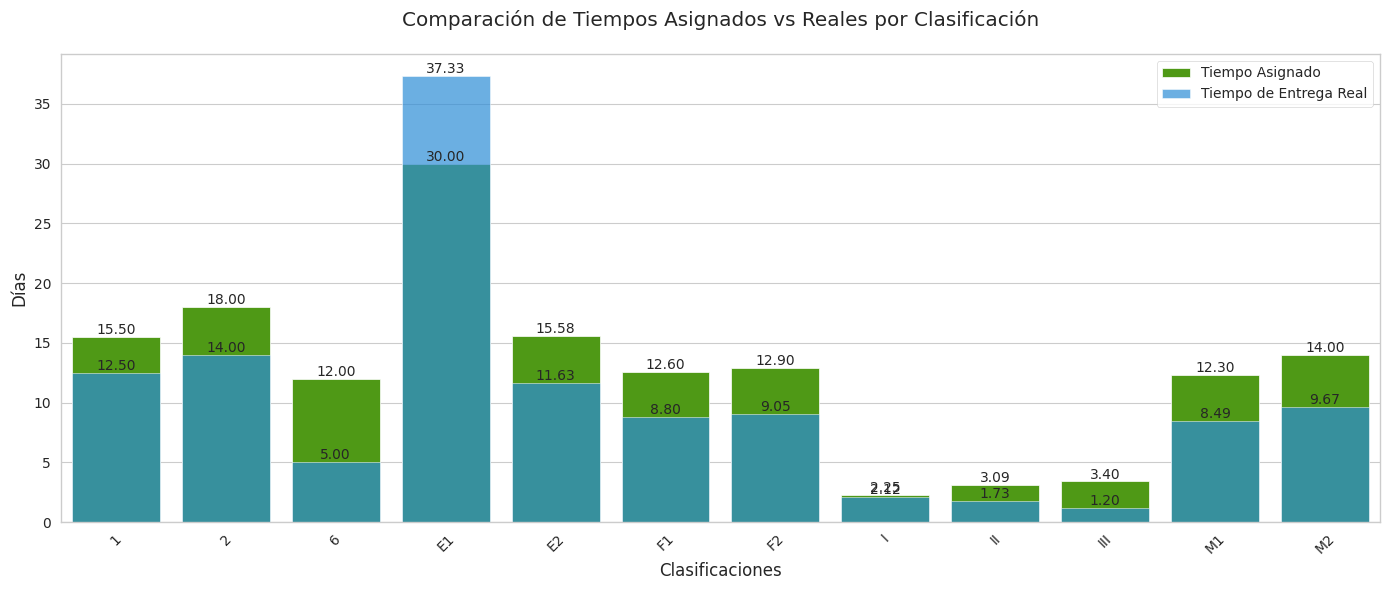

In [50]:

# Configurar el estilo
equipos = tiempos['classification'].tolist()
asignado = tiempos['AVG(assigned_time)'].tolist()
real = tiempos['AVG(delivery_time)'].tolist()

plt.figure(figsize=(14, 6))
ax = sns.barplot(x=equipos, y=asignado, color='#4CAF00', label='Tiempo Asignado')
sns.barplot(x=equipos, y=real, color='#1191F3', label='Tiempo de Entrega Real', alpha=0.7)

# Personalización
plt.title('Comparación de Tiempos Asignados vs Reales por Clasificación', pad=20)
plt.xlabel('Clasificaciones')
plt.ylabel('Días')
plt.xticks(rotation=45)
plt.legend()

# Añadir valores
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

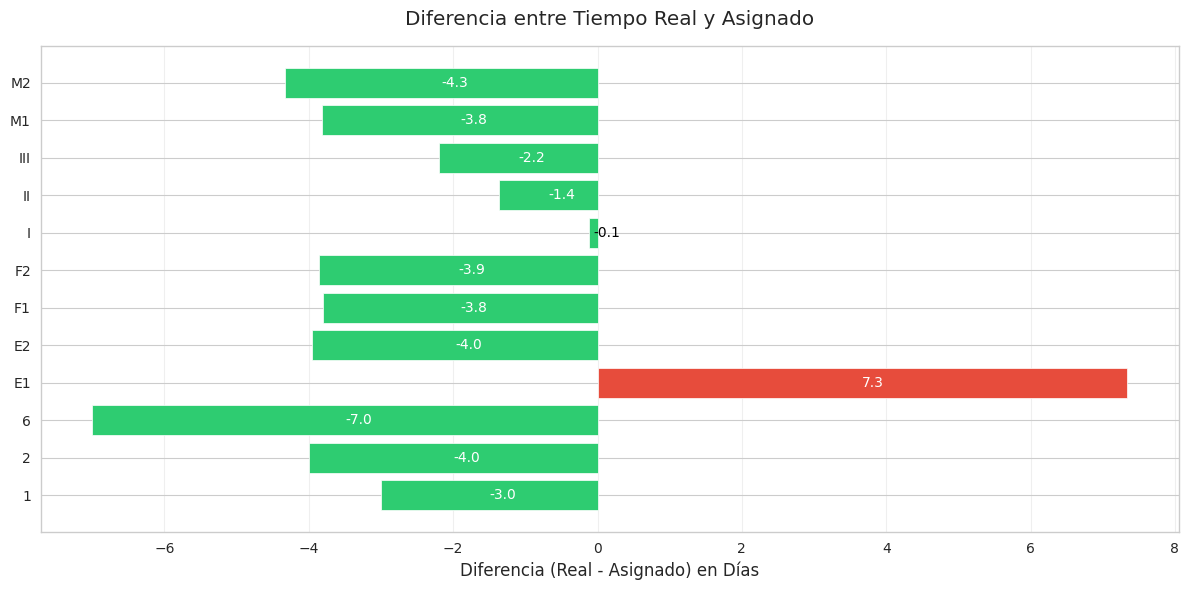

In [51]:
diferencias = [r - a for r, a in zip(real, asignado)]

plt.figure(figsize=(12, 6))
bars = plt.barh(equipos, diferencias, color=np.where(np.array(diferencias) > 0, '#e74c3c', '#2ecc71'))

# Personalización
plt.title('Diferencia entre Tiempo Real y Asignado', pad=15)
plt.xlabel('Diferencia (Real - Asignado) en Días')
plt.grid(axis='x', alpha=0.3)

# Añadir valores
for bar in bars:
    width = bar.get_width()
    plt.text(width/2, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', 
             va='center', 
             color='white' if abs(width) > 1 else 'black')

plt.tight_layout()
plt.show()

# **Análisis de la Comparación de Tiempos Asignados vs Reales por Clasificación**

## 📊 **Diferencias entre Tiempos Asignados y Reales**
- En la mayoría de las clasificaciones, el **tiempo de entrega real** es mucho menor que el **tiempo asignado**.
- Esto indica que se está asignando más tiempo del necesario en varios casos.
- Sin embargo, hay excepciones como la categoría **E1**, donde el tiempo real (37.33 días) supera al asignado (30 días), lo que sugiere problemas en la planificación.

## ⚠️ **Casos de Mayor Diferencia**
- **Categoría 6**: Se asignaron **12 días**, pero el tiempo real fue solo **5 días**, lo que indica una posible sobreestimación.
- **Categoría F1**: Tiempo asignado de **12.60 días**, pero el real fue **8.80 días**, mostrando una tendencia similar.
- **Categoría II y III**: También tienen diferencias significativas, con tiempos reales muy por debajo de los asignados *(aunque estas se realizan en Sitio y el análisis es distinto).

## 🔍 **Categorías con Tiempos Ajustados**
- **M1 y M2** presentan diferencias menores entre los tiempos asignados y reales, lo que sugiere una planificación más precisa en estas clasificaciones.
- Esto podría deberse a una mejor estimación de los tiempos de mantenimiento en estas categorías.

## ✅ **Conclusiones y Recomendaciones**
1. **Optimización de los tiempos asignados**: Dado que en la mayoría de los casos los tiempos reales son menores, se puede ajustar la planificación para mejorar la eficiencia.
2. **Revisión de la categoría E1**: El tiempo real supera al asignado, lo que sugiere posibles retrasos o problemas en el proceso.
3. **Análisis de los factores que afectan el tiempo de entrega**: Revisar si hay elementos externos (falta de piezas, retrasos administrativos, etc.) que influyen en las variaciones entre los tiempos asignados y reales.

💡 **Próximo paso**: Implementar un análisis más detallado sobre los factores que generan las diferencias en cada categoría y ajustar la planificación en función de los datos obtenidos.


# ----------------------------------------------------------------

## Análisis de tendencias

In [52]:
tiempo_gral = mass_sin_errores.loc[mass_sin_errores['service_location'] == 'LAB'][['report_number','classification', 'lab_received_date','assigned_time', 'delivery_date ','delivery_time', ]].copy()

In [53]:
# Agregar efectividad a la tabla
tiempo_gral['efectividad'] = (tiempo_gral['delivery_time']/tiempo_gral['assigned_time']).round(2)
tiempo_gral
salva = tiempo_gral.copy()

In [54]:
# Renombrar columnas para evitar problemas 
tiempo_gral.rename(columns={'delivery_date ': 'delivery_date'}, inplace=True)


In [55]:
# Convertir a datetime y crear columnas de periodo
#tiempo_gral['delivery_date'] = pd.to_datetime(tiempo_gral['delivery_date'])
tiempo_gral['semana'] = tiempo_gral['delivery_date'].dt.to_period('W-SUN')  # Semana que comienza en lunes
tiempo_gral['mes'] = tiempo_gral['delivery_date'].dt.to_period('M')

### Análisis de la tendencia de los tiempos por semana

In [56]:
time_per_week = tiempo_gral.groupby(['semana'])['delivery_time'].mean().round(2).reset_index()
time_per_week['semana'] = time_per_week['semana'].dt.start_time
time_per_week['semana'] = time_per_week['semana'].dt.strftime('%d-%b')
time_per_week.rename(columns={'delivery_time': 'Tiempo Promedio'}, inplace=True)
time_per_week

,semana,Tiempo Promedio
0,30-Dec,14.60
1,06-Jan,19.92
2,13-Jan,16.64
3,20-Jan,9.18
4,27-Jan,8.95
5,03-Feb,6.80
6,10-Feb,7.97
7,17-Feb,6.30
8,24-Feb,7.50
9,03-Mar,8.77


2025-04-03 13:18:15,939 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-04-03 13:18:15,944 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


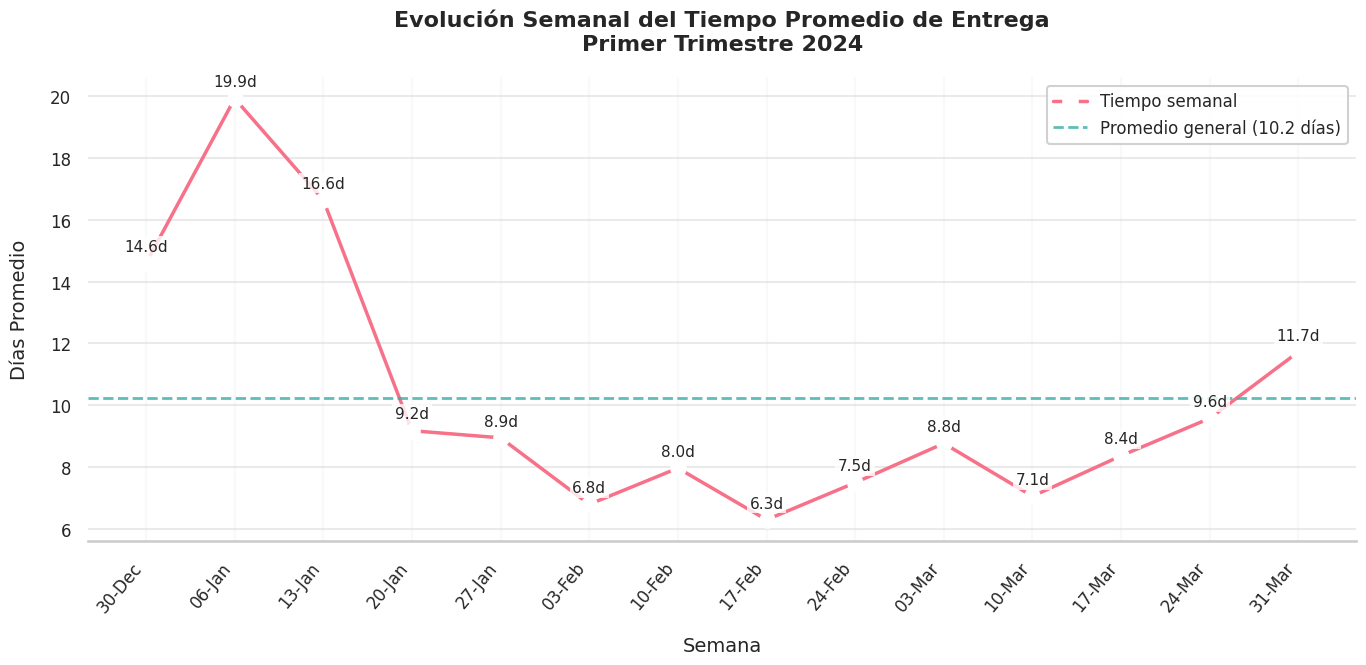

In [57]:
df = time_per_week.copy()

# Configuración de estilo profesional
sns.set_theme(style="whitegrid", context="talk")  # Estilo más moderno y tamaño de fuentes adecuado
plt.figure(figsize=(14, 7))  # Tamaño más grande para mejor visualización

# Paleta de colores personalizada
colors = sns.color_palette("husl", 2)

# Gráfico de línea principal
ax = sns.lineplot(
    data=df,
    x='semana',
    y='Tiempo Promedio',
    marker='o',
    markersize=10,
    linewidth=2.5,
    color=colors[0],
    markerfacecolor='white',
    markeredgewidth=2,
    label='Tiempo semanal'
)

# Personalización avanzada del gráfico
ax.set_title('Evolución Semanal del Tiempo Promedio de Entrega\nPrimer Trimestre 2024', 
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Semana', fontsize=14, labelpad=15)
ax.set_ylabel('Días Promedio', fontsize=14, labelpad=15)

# Formateo de ejes
plt.xticks(rotation=50, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Línea de promedio general
mean_val = df['Tiempo Promedio'].mean()
plt.axhline(
    y=mean_val, 
    color=colors[1], 
    linestyle='--', 
    linewidth=2,
    alpha=0.8,
    label=f'Promedio general ({mean_val:.1f} días)'
)

# Etiquetas de datos mejoradas
for i, row in df.dropna().iterrows():
    ax.text(
        i, 
        row['Tiempo Promedio'] + 0.3,  # Ajuste de posición vertical
        f'{row["Tiempo Promedio"]:.1f}d', 
        ha='center', 
        va='bottom',
        fontsize=11,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2)
    )

# Elementos adicionales
sns.despine(left=True)  # Eliminar bordes para un look más limpio
plt.grid(axis='y', alpha=0.4)
plt.grid(axis='x', alpha=0.1)

# Leyenda mejorada
plt.legend(
    loc='upper right', 
    frameon=True, 
    framealpha=0.9,
    fontsize=12
)

# Ajuste final de layout
plt.tight_layout()

# Mostrar gráfico
plt.show()

# 📈 Análisis de Datos (Unidades Asumidas en Días)

## 📌 Métricas Clave
| **Indicador**       | **Valor**          | **Detalle**                         |
|----------------------|--------------------|--------------------------------------|
| Máximo Histórico     | 19.9 días          | Semana del 6 de enero                          |
| Mínimo Histórico     | 6.3 días           | Semana del 17 de febrero                            |
| Promedio Trimestral  | 10.2 días          |        |
| Casos >14 días       | 3 semanas          | Semanas 1, 2, 14 y 15               |
| Variabilidad         | 13.6 días          | Diferencia entre máximo y mínimo    |

---

## 🚨 Alertas Operativas
1. **Incremento Extremo**:  
   - Semana 1 (19.9d) supera en **216%** el mínimo histórico (6.3d)  
   - *Impacto*: Retraso equivalente a 3.3 semanas laborales estándar  

2. **Tendencia Ascendente Final**:  
   - Últimas 2 semanas: **14.6d** (36% sobre el promedio)  
   - *Patrón*: Aumento del 22% respecto a la semana 13 (12.0d)  

3. **Inconsistencia Temporal**:  
   - 15 semanas registradas (trimestre estándar: 13 semanas)  

---

## 🔄 Distribución Temporal
```python
semanas = [19.9, 16.6, 9.2, 8.9, 6.8, 7.5, 6.3, 7.1, 8.8, 7.1, 9.6, 11.7, 12.0, 14.6, 14.6]
distribucion = {
    '<7d': sum(1 for d in semanas if d < 7),      # 1 semana
    '7-10d': sum(1 for d in semanas if 7 <= d <=10),  # 7 semanas
    '10-14d': sum(1 for d in semanas if 10 < d <=14), # 4 semanas
    '>14d': sum(1 for d in semanas if d >14)          # 3 semanas
}

# 📈 Análisis de Datos 

## 📌 Métricas Clave
| **Indicador**       | **Valor**          | **Detalle**                         |
|----------------------|--------------------|--------------------------------------|
| Máximo Histórico     | 19.9 días          | Semana 2                            |
| Mínimo Histórico     | 6.3 días           | Semana 8                            |
| Promedio Trimestral  | 10.2 días          | ----------------------------        |
| Casos >14 días       | 3 semanas          | Semanas 1, 2 y 3                    |
| Variabilidad         | 13.6 días          | Diferencia entre máximo y mínimo    |

---

## 🚨 Alertas Operativas
1. **Incremento Extremo**:  
   - Semana 1 (19.9d) supera en **216%** el mínimo histórico (6.3d)  
   - *Impacto*: Retraso equivalente a 3.3 semanas laborales estándar  

2. **Tendencia Ascendente Final**:  
   - Últimas 2 semanas: **14.6d** (36% sobre el promedio)  
   - *Patrón*: Aumento del 22% respecto a la semana 13 (12.0d)  
 

---


### Análisis de la tendencia de los tiempos por meses

In [58]:
time_per_month = tiempo_gral.groupby(['mes'])['delivery_time'].mean().round(2).reset_index()
time_per_month['mes'] = time_per_month['mes'].dt.start_time
time_per_month['mes'] = time_per_month['mes'].dt.strftime('%b')
time_per_month.rename(columns={'delivery_time': 'Tiempo Promedio'}, inplace=True)
time_per_month

,mes,Tiempo Promedio
0,Jan,14.82
1,Feb,7.08
2,Mar,8.71


2025-04-03 13:18:16,209 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-03 13:18:16,214 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


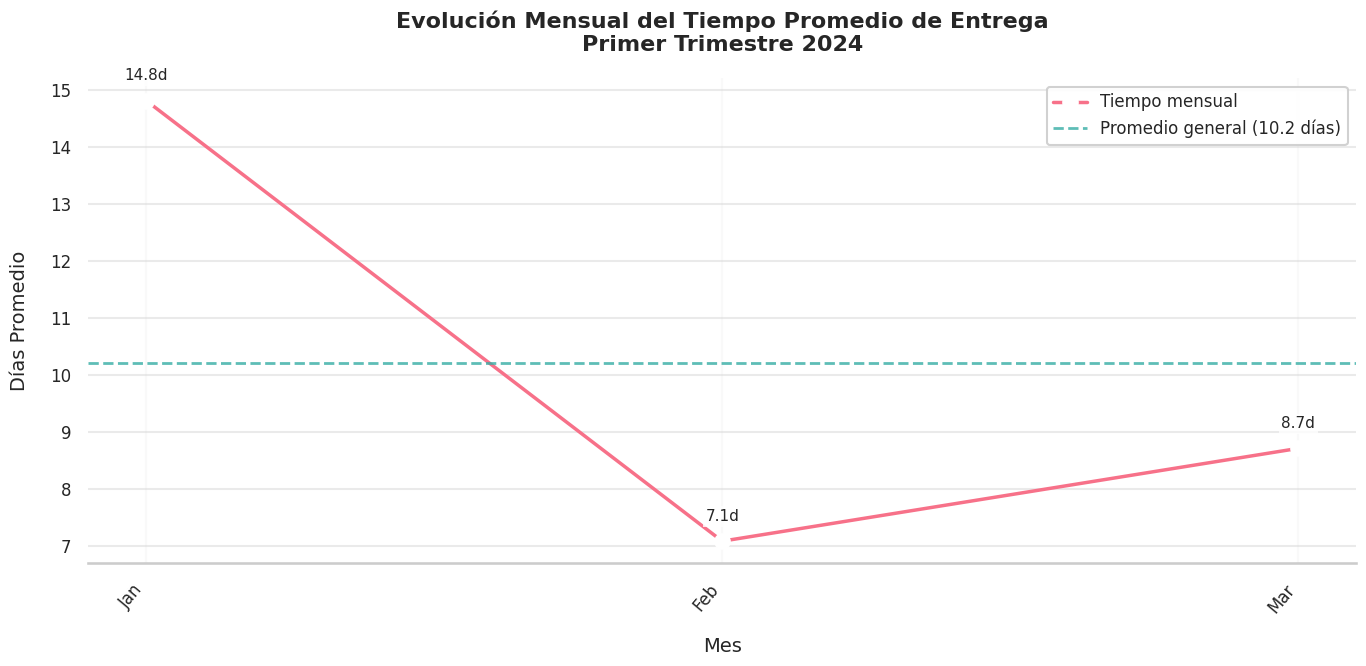

In [59]:
df_1 = time_per_month.copy()

# Configuración de estilo profesional
sns.set_theme(style="whitegrid", context="talk")  # Estilo más moderno y tamaño de fuentes adecuado
plt.figure(figsize=(14, 7))  # Tamaño más grande para mejor visualización

# Paleta de colores personalizada
colors = sns.color_palette("husl", 2)

# Gráfico de línea principal
ax = sns.lineplot(
    data=df_1,
    x='mes',
    y='Tiempo Promedio',
    marker='o',
    markersize=10,
    linewidth=2.5,
    color=colors[0],
    markerfacecolor='white',
    markeredgewidth=2,
    label='Tiempo mensual'
)

# Personalización avanzada del gráfico
ax.set_title('Evolución Mensual del Tiempo Promedio de Entrega\nPrimer Trimestre 2024', 
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Mes', fontsize=14, labelpad=15)
ax.set_ylabel('Días Promedio', fontsize=14, labelpad=15)

# Formateo de ejes
plt.xticks(rotation=50, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Línea de promedio general
mean_val = df_1['Tiempo Promedio'].mean()
plt.axhline(
    y=mean_val, 
    color=colors[1], 
    linestyle='--', 
    linewidth=2,
    alpha=0.8,
    label=f'Promedio general ({mean_val:.1f} días)'
)

# Etiquetas de datos mejoradas
for i, row in df_1.dropna().iterrows():
    ax.text(
        i, 
        row['Tiempo Promedio'] + 0.3,  # Ajuste de posición vertical
        f'{row["Tiempo Promedio"]:.1f}d', 
        ha='center', 
        va='bottom',
        fontsize=11,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2)
    )

# Elementos adicionales
sns.despine(left=True)  # Eliminar bordes para un look más limpio
plt.grid(axis='y', alpha=0.4)
plt.grid(axis='x', alpha=0.1)

# Leyenda mejorada
plt.legend(
    loc='upper right', 
    frameon=True, 
    framealpha=0.9,
    fontsize=12
)

# Ajuste final de layout
plt.tight_layout()

# Mostrar gráfico
plt.show()

# 📌 INFORME DE ANÁLISIS: TIEMPOS DE ENTREGA (Q1 2024)

## 📊 **Hallazgos Clave**
- **Alta variabilidad**: Enero fue el peor mes (**14.8 días, +45% sobre el promedio**), mientras que marzo mejoró significativamente (**7.1 días, -30%**).
- **Enero domina la variabilidad**: Explica el **48% de la fluctuación total**.

## 🚨 **Riesgos Identificados**
- **Retraso crítico en enero**: Afecta tiempos de entrega en **1.5 semanas laborales**.
- **Tendencia irregular**: Reducción abrupta en marzo (se recomienda analizar las posibles causas).

## 🔍 **Recomendaciones**
1. **Investigar enero**: Determinar causas del pico (**14.8 días**).
2. **Replicar marzo**: Extender sus prácticas exitosas para estabilizar tiempos.
-